#  Chapter 12 – Custom Models and Training with TensorFlow

## 12.1 A Quick Tour of TensorFlow

* Up until now, we’ve used only TensorFlow’s high-level API, tf.keras, but italready got us pretty far: we built various neural network architectures, including regression and classification nets, Wide & Deep nets, and self-normalizing nets,using all sorts of techniques, such as Batch Normalization, dropout, and learning rate schedules. In fact, 95% of the use cases you will encounter will not requireanything other than tf.keras (and tf.data; see Chapter 13). 
* But now it’s time to dive deeper into TensorFlow and take a look at its lower-level Python API. Thiswill be useful when you need extra control to write custom loss functions, custom metrics, layers, models, initializers, regularizers, weight constraints, and more. 

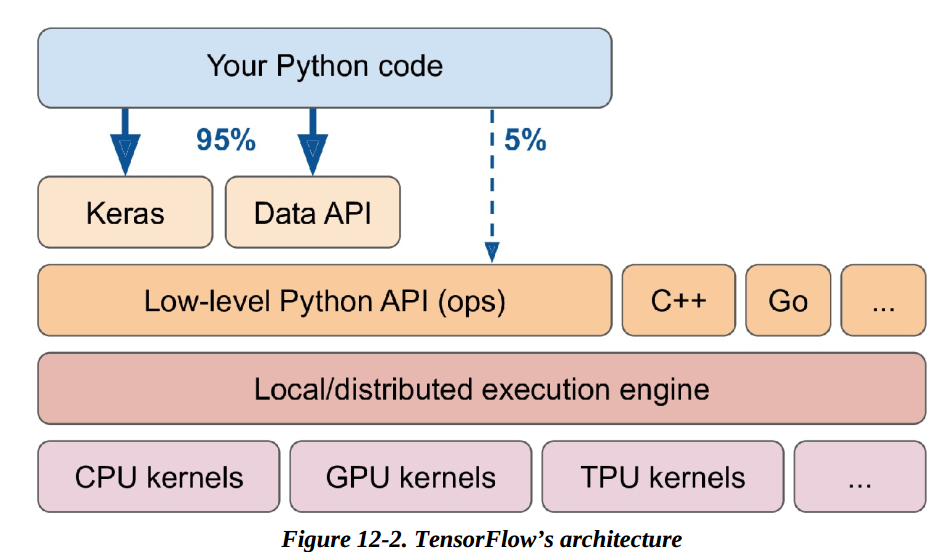

* TensorFlow is a powerful library for numerical computation,particularly well suited and fine-tuned for large-scale Machine Learning. Countless projects use TensorFlow for all sorts of Machine Learning tasks, such as image classification, natural language processing, recommender systems, and time series forecasting.

So what does TensorFlow offer? Here’s a summary:
* Its core is very similar to NumPy, but with GPU support.
* It supports distributed computing (across multiple devices and servers).
* It includes a kind of just-in-time (JIT) compiler that allows it to optimize computations for speed and memory usage. 
* Computation graphs can be exported to a portable format, so you can train a TensorFlow model in one environment (e.g., using Python on Linux) and run it in another (e.g., using Java on an Android device).
* It implements autodiff (see Chapter 10 and Appendix D) and provides some excellent optimizers, such as RMSProp and Nadam (see Chapter 11), so you can easily minimize all sorts of loss functions.

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import warnings
warnings.filterwarnings("ignore")

import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 12.2 Using TensorFlow like NumPy

**Tensors**: A tensor is usually a multidimensional
array (exactly like a NumPy ndarray), but it can also hold a scalar (a simple
value, such as 42). TensorFlow’s API revolves around tensors, which flow from operation to
operation—hence the name TensorFlow.

In [2]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix

<tf.Tensor: id=0, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(42) # scalar

<tf.Tensor: id=2, shape=(), dtype=int32, numpy=42>

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: id=4, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [5]:
t.shape

TensorShape([2, 3])

In [6]:
t.dtype

tf.float32

### Indexing

In [7]:
t[:, 1:]

<tf.Tensor: id=9, shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [8]:
t[:, 1]

<tf.Tensor: id=14, shape=(2,), dtype=float32, numpy=array([2., 5.], dtype=float32)>

In [9]:
t[..., 1]

<tf.Tensor: id=19, shape=(2,), dtype=float32, numpy=array([2., 5.], dtype=float32)>

In [10]:
t[..., 1, tf.newaxis]  #tf.newaxis给tensor增加维度

<tf.Tensor: id=24, shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### Ops

In [11]:
t + 10

<tf.Tensor: id=27, shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [12]:
tf.add(t,10)

<tf.Tensor: id=30, shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [13]:
tf.square(t)

<tf.Tensor: id=32, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [14]:
t @ tf.transpose(t)  #@ 矩阵乘法

<tf.Tensor: id=36, shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### Using `keras.backend`

In [15]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: id=42, shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### Tensors and NumPy

In [16]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: id=44, shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [17]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [18]:
np.array(t)  #与上一个命令结果一致

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [19]:
tf.square(a)

<tf.Tensor: id=48, shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [20]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### Conflicting Types

In [21]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute Add as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:Add] name: add/


In [22]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute Add as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Add] name: add/


In [23]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: id=57, shape=(), dtype=float32, numpy=42.0>

### Variable

In [24]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [25]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [26]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [27]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [28]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [29]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
print(sparse_delta) 
v.scatter_update(sparse_delta)

IndexedSlices(indices=[1, 0], values=[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])


<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

### Strings

In [30]:
tf.constant(b"hello world")  # byte string

<tf.Tensor: id=96, shape=(), dtype=string, numpy=b'hello world'>

In [31]:
tf.constant("café")    # Unicode string

<tf.Tensor: id=98, shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [32]:
u = tf.constant([ord(c) for c in "café"])  #ord(c)返回对应的 ASCII 数值
u

<tf.Tensor: id=100, shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [33]:
b = tf.strings.unicode_encode(u, "UTF-8")
b

<tf.Tensor: id=111, shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [34]:
tf.strings.length(b, unit="UTF8_CHAR")   #长度不显示在张量的shape中

<tf.Tensor: id=113, shape=(), dtype=int32, numpy=4>

In [35]:
tf.strings.unicode_decode(b, "UTF-8")   #长度显示

<tf.Tensor: id=118, shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

### String arrays

In [36]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])
p

<tf.Tensor: id=120, shape=(4,), dtype=string, numpy=
array([b'Caf\xc3\xa9', b'Coffee', b'caff\xc3\xa8',
       b'\xe5\x92\x96\xe5\x95\xa1'], dtype=object)>

In [37]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: id=122, shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2])>

In [38]:
r = tf.strings.unicode_decode(p, "UTF8")
r

tf.RaggedTensor(values=tf.Tensor(
[   67    97   102   233    67   111   102   102   101   101    99    97
   102   102   232 21654 21857], shape=(17,), dtype=int32), row_splits=tf.Tensor([ 0  4 10 15 17], shape=(5,), dtype=int64))

In [39]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>


### Ragged tensors   不规则张量

In [40]:
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [41]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [42]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
print(tf.concat([r, r2], axis=0))  #按列拼接

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


In [43]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1)) #按行拼接

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71], [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [44]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: id=285, shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

In [45]:
r.to_tensor()   #不规则转化为规则

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor: id=351, shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]])>

### Sparse tensors

In [46]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]], #非零值的索引值
                    values=[1., 2., 3.],              #非零值
                    dense_shape=[3, 4])               #稀疏矩阵的形状

In [47]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [48]:
tf.sparse.to_dense(s)

<tf.Tensor: id=360, shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [49]:
s2 = s * 2.0

In [50]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [51]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)  ##矩阵乘法

<tf.Tensor: id=365, shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [52]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],   #indices要求按顺序排列
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [53]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order [Op:SparseToDense]


In [54]:
s6 = tf.sparse.reorder(s5)
print(s6)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [0 2]], shape=(2, 2), dtype=int64), values=tf.Tensor([2. 1.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [55]:
tf.sparse.to_dense(s6)

<tf.Tensor: id=383, shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### Sets

In [56]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))#按行取并集，剔除重复值，不足维数补0

<tf.Tensor: id=391, shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]])>

In [57]:
tf.sparse.to_dense(tf.sets.difference(set1, set2)) #按行取差集，不足维数补0

<tf.Tensor: id=397, shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]])>

In [58]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))  #按行取交集，不足维数补0

<tf.Tensor: id=403, shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]])>

### Tensor Arrays

In [59]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))
array

In [60]:
array.read(1)

<tf.Tensor: id=407, shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [61]:
array.stack()  #用于矩阵拼接

<tf.Tensor: id=413, shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [62]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: id=422, shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [63]:
variance

<tf.Tensor: id=423, shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

## 12.3 Customizing Models and Training Algorithms

### 12.3.1 Custom loss function

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [64]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [65]:
housing.data.shape,  housing.target.reshape(-1, 1).shape

((20640, 8), (20640, 1))

In [66]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

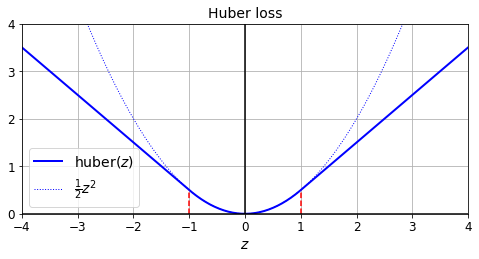

In [67]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [68]:
X_train.shape[1:]

(8,)

In [69]:
input_shape = X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [70]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])  ##metrics，评估标准

In [71]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 79us/sample - loss: 0.6229 - mae: 0.9934 - val_loss: 0.2816 - val_mae: 0.5838
Epoch 2/2
11610/11610 [==============================] - 1s 49us/sample - loss: 0.2190 - mae: 0.5173 - val_loss: 0.2365 - val_mae: 0.5216


## Saving/Loading Models with Custom Objects

In [72]:
model.save("my_model_with_a_custom_loss.h5")

In [73]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [74]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 98us/sample - loss: 0.2048 - mae: 0.4976 - val_loss: 0.2126 - val_mae: 0.4968
Epoch 2/2
11610/11610 [==============================] - 2s 133us/sample - loss: 0.2002 - mae: 0.4911 - val_loss: 0.1978 - val_mae: 0.4826


In [75]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [76]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [77]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 2s 171us/sample - loss: 0.2224 - mae: 0.4894 - val_loss: 0.2410 - val_mae: 0.4816
Epoch 2/2
11610/11610 [==============================] - 1s 109us/sample - loss: 0.2180 - mae: 0.4845 - val_loss: 0.2252 - val_mae: 0.4751


In [78]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [79]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [80]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 71us/sample - loss: 0.2145 - mae: 0.4794 - val_loss: 0.2060 - val_mae: 0.4654
Epoch 2/2
11610/11610 [==============================] - 1s 50us/sample - loss: 0.2118 - mae: 0.4767 - val_loss: 0.2022 - val_mae: 0.4564


In [81]:
class HuberLoss(keras.losses.Loss):   ##可以保存训练时设定的阈值
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [82]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [83]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [84]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 76us/sample - loss: 0.6982 - mae: 0.8827 - val_loss: 0.3284 - val_mae: 0.5434
Epoch 2/2
11610/11610 [==============================] - 1s 50us/sample - loss: 0.2399 - mae: 0.5068 - val_loss: 0.2621 - val_mae: 0.5015


In [85]:
model.save("my_model_with_a_custom_loss_class.h5")

In [86]:
# model = keras.models.load_model("my_model_with_a_custom_loss_class.h5", # TODO: check PR #25956
#                               custom_objects={"HuberLoss": HuberLoss})

In [87]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 95us/sample - loss: 0.2278 - mae: 0.4964 - val_loss: 0.2221 - val_mae: 0.4799
Epoch 2/2
11610/11610 [==============================] - 2s 129us/sample - loss: 0.2210 - mae: 0.4903 - val_loss: 0.2182 - val_mae: 0.4733


In [88]:
model.loss.threshold

2.0

## Other Custom Functions

In [89]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [90]:
def my_softplus(z): # return value is just tf.nn.softplus(z)  #激活函数
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):          #初始化函数
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):                              #l1正则化
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)   #relu
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [91]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [92]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [93]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [94]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 2s 182us/sample - loss: 1.4943 - mae: 0.8850 - val_loss: 1.5203 - val_mae: 0.5619
Epoch 2/2
11610/11610 [==============================] - 2s 150us/sample - loss: 0.5918 - mae: 0.5268 - val_loss: 1.5022 - val_mae: 0.5096


In [95]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [96]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [97]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [98]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [99]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 87us/sample - loss: 1.4943 - mae: 0.8850 - val_loss: 1.5203 - val_mae: 0.5619
Epoch 2/2
11610/11610 [==============================] - 1s 48us/sample - loss: 0.5918 - mae: 0.5268 - val_loss: 1.5022 - val_mae: 0.5096


## Custom Metrics

In [100]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [101]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [102]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [103]:
model.fit(X_train_scaled, y_train, epochs=2)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 62us/sample - loss: 2.0877 - huber_fn: 0.9235
Epoch 2/2
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5860 - huber_fn: 0.2688


**Warning**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [104]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [105]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 2s 154us/sample - loss: 0.1190 - huber_fn: 0.2372
Epoch 2/2
11610/11610 [==============================] - 1s 93us/sample - loss: 0.1144 - huber_fn: 0.2294


In [106]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11902356644471486, 0.11947351531016903)

### Streaming metrics

In [107]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])      # precision=0.8  ##(true,predict)(4/5)

<tf.Tensor: id=73546, shape=(), dtype=float32, numpy=0.8>

In [108]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])      # precision=0.5 so far    (0/3)

<tf.Tensor: id=73596, shape=(), dtype=float32, numpy=0.5>

In [109]:
precision.result()     

<tf.Tensor: id=73606, shape=(), dtype=float32, numpy=0.5>

In [110]:
precision.variables   #tracking the number of true and false positives

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [111]:
precision.reset_states()      # reset variables

Creating a streaming metric:

In [112]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def huber_fn(self, y_true, y_pred): # workaround
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

**Warning**: when running the following cell, if you get autograph warnings such as `WARNING:tensorflow:AutoGraph could not transform [...] and will run it as-is`, then please install version 0.2.2 of the gast library (e.g., by running `!pip install gast==0.2.2`), then restart the kernel and run this notebook again from the beginning (see [autograph issue #1](https://github.com/tensorflow/autograph/issues/1) for more details):

In [113]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: id=73656, shape=(), dtype=float32, numpy=14.0>

In [114]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))
m.result()

<tf.Tensor: id=73688, shape=(), dtype=float32, numpy=7.0>

In [115]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [116]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the `HuberMetric` class works well:

In [117]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [118]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [119]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [120]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 100us/sample - loss: 0.8717 - huber_metric: 0.8717
Epoch 2/2
11610/11610 [==============================] - 0s 38us/sample - loss: 0.2567 - huber_metric: 0.2567


In [121]:
model.save("my_model_with_a_custom_metric.h5")

**Warning**: In TF 2.2, tf.keras adds an extra first metric in `model.metrics` at position 0 (see [TF issue #38150](https://github.com/tensorflow/tensorflow/issues/38150)). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the `HuberMetric`.

In [122]:
model.metrics[-1].threshold

2.0

## Custom Layers

In [123]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))   #create a custom layer without any weights

In [124]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: id=79847, shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [125]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [126]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/5
11610/11610 [==============================] - 1s 58us/sample - loss: 13681315343445.7832 - val_loss: inf
Epoch 2/5
11610/11610 [==============================] - 1s 47us/sample - loss: 493578.6405 - val_loss: inf
Epoch 3/5
11610/11610 [==============================] - 1s 47us/sample - loss: 274951.7519 - val_loss: inf
Epoch 4/5
11610/11610 [==============================] - 0s 41us/sample - loss: 129438.4480 - val_loss: inf
Epoch 5/5
5160/5160 [==============================] - 0s 18us/sample - loss: 1728.5668


1728.566812913917

 * Compute the outputs of a layer of artificial neurons for several instances
$$h_{W,b}(X)=\phi(XW+b)$$

In [127]:
class MyDense(keras.layers.Layer):                  #  create a custom layer with some weights
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [128]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [129]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [130]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 107us/sample - loss: 2.2287 - val_loss: 0.8403
Epoch 2/2
5160/5160 [==============================] - 0s 37us/sample - loss: 0.5475


0.5475413460140081

In [131]:
model.save("my_model_with_a_custom_layer.h5")

In [132]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [133]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [134]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [135]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

Let's create a layer with a different behavior during training and testing:

In [136]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [137]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    AddGaussianNoise(1),
    keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="nadam")  ##此处model 没有编译
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 105us/sample - loss: 2.7975 - val_loss: 2.3944
Epoch 2/2
5160/5160 [==============================] - 0s 20us/sample - loss: 0.6114


0.6114404785540677

## Custom Models

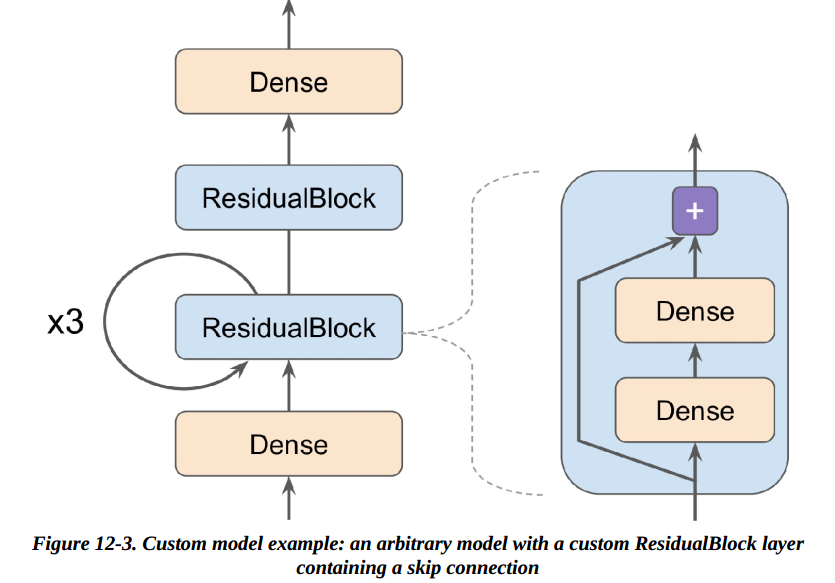

In [138]:
X_new_scaled = X_test_scaled

In [139]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [140]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [141]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [142]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Train on 11610 samples
Epoch 1/5
11610/11610 [==============================] - 1s 98us/sample - loss: 7.5186
Epoch 2/5
11610/11610 [==============================] - 1s 53us/sample - loss: 1.2075
Epoch 3/5
11610/11610 [==============================] - 1s 51us/sample - loss: 0.9618
Epoch 4/5
11610/11610 [==============================] - 1s 51us/sample - loss: 1.1055
Epoch 5/5
5160/5160 [==============================] - 0s 70us/sample - loss: 0.5896


In [143]:
model.save("my_custom_model.ckpt")

INFO:tensorflow:Assets written to: my_custom_model.ckpt\assets


In [144]:
model = keras.models.load_model("my_custom_model.ckpt")

In [145]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Train on 11610 samples
Epoch 1/5
11610/11610 [==============================] - 2s 141us/sample - loss: 0.5891
Epoch 2/5
11610/11610 [==============================] - 1s 129us/sample - loss: 0.4730
Epoch 3/5
11610/11610 [==============================] - 2s 178us/sample - loss: 0.4690
Epoch 4/5
11610/11610 [==============================] - 2s 173us/sample - loss: 0.5270
Epoch 5/5
11610/11610 [==============================] - 3s 291us/sample - loss: 0.5130


We could have defined the model using the sequential API instead:

In [146]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [147]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, 
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [148]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Train on 11610 samples
Epoch 1/5
11610/11610 [==============================] - 5s 392us/sample - loss: 1.0030
Epoch 2/5
11610/11610 [==============================] - 2s 212us/sample - loss: 0.4990
Epoch 3/5
11610/11610 [==============================] - 2s 182us/sample - loss: 0.5981
Epoch 4/5
11610/11610 [==============================] - 2s 182us/sample - loss: 0.4035
Epoch 5/5
5160/5160 [==============================] - 0s 27us/sample - loss: 0.3956


## Losses and Metrics Based on Model Internals

In [149]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))  #
        self.add_loss(0.05 * recon_loss)
        return self.out(Z)

In [150]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [151]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)   ##损失中包含内部重建损失

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 109us/sample - loss: 0.7724
Epoch 2/2
11610/11610 [==============================] - 1s 60us/sample - loss: 0.4129


## Computing Gradients with Autodiff

In [152]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

* Finite Difference Approximation

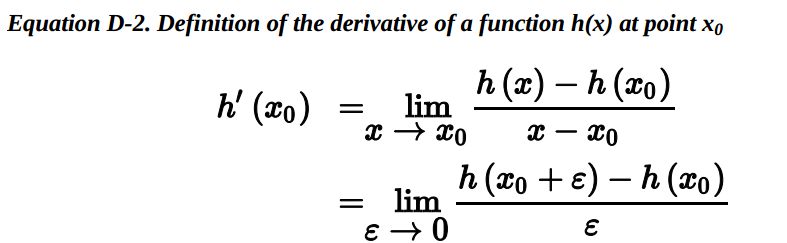

In [153]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [154]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

* Autodiff

In [155]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [156]:
gradients

[<tf.Tensor: id=149903, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=149876, shape=(), dtype=float32, numpy=10.0>]

In [157]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

GradientTape.gradient can only be called once on non-persistent tapes.


In [158]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [159]:
dz_dw1, dz_dw2

(<tf.Tensor: id=149991, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=149996, shape=(), dtype=float32, numpy=10.0>)

In [160]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[None, None]

In [161]:
with tf.GradientTape() as tape:   #you can force the tape to watch any tensors you like, to record every operation that involves them
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: id=150074, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=150047, shape=(), dtype=float32, numpy=10.0>]

In [162]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: id=150102, shape=(), dtype=float32, numpy=30.0>, None]

In [163]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: id=150132, shape=(), dtype=float32, numpy=nan>]

In [164]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: id=150138, shape=(), dtype=float32, numpy=30.0>

In [165]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: id=150157, shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [166]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [167]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [168]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: id=150175, shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: id=150196, shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

# Custom Training Loops

In [169]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [170]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [171]:
def random_batch(X, y, batch_size=32):   # randomly sample a batch of instances
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [172]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [173]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [174]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [175]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [176]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))  #主损失
            loss = tf.add_n([main_loss] + model.losses)           #主损失+正则化损失
        gradients = tape.gradient(loss, model.trainable_variables) #计算梯度
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))  #梯度下降
        for variable in model.variables:                #权重约束
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.4384 - mean_absolute_error: 0.58792
Epoch 2/5
11610/11610 [==============================] - mean: 0.6721 - mean_absolute_error: 0.5281
Epoch 3/5
11610/11610 [==============================] - mean: 0.6342 - mean_absolute_error: 0.5185
Epoch 4/5
11610/11610 [==============================] - mean: 0.6394 - mean_absolute_error: 0.5187
Epoch 5/5
11610/11610 [==============================] - mean: 0.6434 - mean_absolute_error: 0.5216


## TensorFlow Functions

In [177]:
def cube(x):
    return x ** 3

In [178]:
cube(2)

8

In [179]:
cube(tf.constant(2.0))

<tf.Tensor: id=803866, shape=(), dtype=float32, numpy=8.0>

*  use tf.function() to convert this Python function to a TensorFlow Function

In [180]:
tf_cube = tf.function(cube)
tf_cube

In [181]:
tf_cube(2)

<tf.Tensor: id=803873, shape=(), dtype=int32, numpy=8>

In [182]:
tf_cube(tf.constant(2.0))

<tf.Tensor: id=803882, shape=(), dtype=float32, numpy=8.0>

In [183]:
@tf.function
def tf_cube(x):
    return x ** 3

In [184]:
tf_cube(2)

<tf.Tensor: id=803889, shape=(), dtype=int32, numpy=8>

*  a TF Function will usually run much faster than the original Python function, especially if it performs complex computations.
* By default, tf.keras will automatically convert your custom code into TF Functions, no need to use `tf.function()`.